<!-- https://www.kaggle.com/code/iakhtar0/63-next-word-predictor-lstm-campusx -->

In [1]:
import sys
import platform
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import nltk
import sklearn

print("🔧 Environment Information")
print("=" * 40)
print(f"Python version      : {platform.python_version()}")
print(f"TensorFlow version  : {tf.__version__}")
print(f"NumPy version       : {np.__version__}")
print(f"Pandas version      : {pd.__version__}")
print(f"Matplotlib version  : {matplotlib.__version__}")
print(f"Seaborn version     : {sns.__version__}")
print(f"NLTK version        : {nltk.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")
print("=" * 40)

# Optional: GPU info
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU detected: {gpus[0].name}")
else:
    print("⚠️ No GPU detected (running on CPU).")


2025-11-18 16:38:59.966801: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


🔧 Environment Information
Python version      : 3.12.3
TensorFlow version  : 2.20.0
NumPy version       : 2.3.4
Pandas version      : 2.3.3
Matplotlib version  : 3.10.7
Seaborn version     : 0.13.2
NLTK version        : 3.9.2
scikit-learn version: 1.7.2
✅ GPU detected: /physical_device:GPU:0


In [2]:
# Deep Learning library
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.layers import Conv1D, Dropout, MaxPooling1D
from tensorflow.keras import backend as K
import tensorflow as tf
print(tf.__version__)

2.20.0


In [3]:
# Limit TensorFlow memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

# Limit TensorFlow CPU threads
tf.config.threading.set_inter_op_parallelism_threads(2)
tf.config.threading.set_intra_op_parallelism_threads(2)

In [4]:
from pathlib import Path
NOTEBOOK_DIR  = Path().resolve()
BASE_DIR = NOTEBOOK_DIR.parents[0]
DATASET_DIR = BASE_DIR /  "data" / 'Twitter' / "preprocessed"
DATASET_FILE_PATH = DATASET_DIR  / 'train.csv'
print("Base directory",BASE_DIR)
print("Dataset exists :",DATASET_FILE_PATH.exists())

Base directory /home/srirama/sr_proj/EmotionAnalysis
Dataset exists : True


In [5]:
df = pd.read_csv(DATASET_FILE_PATH,usecols=["sentiment","cleaned_text"],nrows=100)
df["cleaned_text"] = df["cleaned_text"].astype(str)
df.isnull().sum()

sentiment       0
cleaned_text    0
dtype: int64

In [6]:
import matplotlib.pyplot as plt
df["word_count"] = df["cleaned_text"].apply(lambda x: len(x.split()))
max_words = df["word_count"].max()
avg_words = df["word_count"].mean()
print("Max words in a sentence:", max_words)
print("Average words in a sentence:", avg_words)

Max words in a sentence: 57
Average words in a sentence: 24.11


In [7]:
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [8]:
tokenizer = Tokenizer(oov_token="None")
# Gives ID to each word in the sentences (entire column)
tokenizer.fit_on_texts(df['cleaned_text'])
vocab_size  = len(tokenizer.word_index) # 31774 unique words
print("Total unique words : ", vocab_size )
print("Unique words with indices",tokenizer.word_index)

Total unique words :  404
Unique words with indices {'None': 1, 'i': 2, 'to': 3, 'the': 4, 'a': 5, 'in': 6, 'borderlands': 7, 'day': 8, 'for': 9, 'any': 10, 'now': 11, 'you': 12, 'this': 13, 'that': 14, 'significant': 15, 'other': 16, 'old': 17, 'fart': 18, 'realy': 19, 'fun': 20, 'some': 21, 'am': 22, 'is': 23, 'out': 24, 'be': 25, 'mayhem': 26, 'my': 27, 'it': 28, 'on': 29, 'was': 30, 'here': 31, 'up': 32, 'get': 33, 'one': 34, 'we': 35, 'drops': 36, 'going': 37, 'game': 38, 'modifiers': 39, 'wil': 40, 'can': 41, 'if': 42, 'have': 43, 'but': 44, 'got': 45, 'god': 46, 'life': 47, 'stream': 48, 'new': 49, 'stupid': 50, 'prety': 51, 'thank': 52, 'man': 53, 'bit': 54, 've': 55, 'play': 56, 'al': 57, 'me': 58, 'make': 59, 'live': 60, 'had': 61, 'fuck': 62, 'tomorow': 63, 'while': 64, 'coming': 65, 'time': 66, 'last': 67, 'catch': 68, 'real': 69, 'wait': 70, 'hanging': 71, 'not': 72, 'finish': 73, 'until': 74, 'hard': 75, 'la': 76, 'rare': 77, 'handsome': 78, 'xbox': 79, 'like': 80, 'exper

In [9]:
sequences  = tokenizer.texts_to_sequences(df['cleaned_text'])
print("Total Sequences",len(sequences) )# = total rows
print("Length of 1st sequence",len(sequences[0])) # = 1st row word count
sequences[:4]

Total Sequences 100
Length of 1st sequence 14


[[2, 22, 65, 3, 4, 267, 10, 8, 11, 2, 40, 244, 12, 57],
 [2, 22, 218, 29, 7, 10, 8, 11, 2, 40, 244, 12, 57],
 [2, 22, 65, 29, 7, 10, 8, 11, 2, 40, 219, 12, 57],
 [2, 22, 218, 29, 7, 10, 8, 11, 2, 40, 219, 12, 58, 57]]

In [10]:
df.head(5)

,sentiment,cleaned_text,word_count
0,Positive,i am coming to the borders any day now i wil k...,14
1,Positive,i am geting on borderlands any day now i wil k...,13
2,Positive,i am coming on borderlands any day now i wil m...,13
3,Positive,i am geting on borderlands any day now i wil m...,14
4,Positive,i am geting into borderlands any day now i can...,13


In [11]:
maxlen = 75
padded_sentence_sequences = pad_sequences(sequences, maxlen = maxlen, padding='pre')
print("Padded Sequence shape :",padded_sentence_sequences.shape)
padded_sentence_sequences

Padded Sequence shape : (100, 75)


array([[  0,   0,   0, ..., 244,  12,  57],
       [  0,   0,   0, ..., 244,  12,  57],
       [  0,   0,   0, ..., 219,  12,  57],
       ...,
       [  0,   0,   0, ..., 216, 217,  31],
       [  0,   0,   0, ..., 216, 217,  31],
       [  0,   0,   0, ..., 216, 217,  31]], shape=(100, 75), dtype=int32)

In [12]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['sentiment'])
y = to_categorical(y_encoded)  # one-hot encode for multi-class

In [13]:
from keras.models import Sequential
from keras.layers import SimpleRNN , Dense , Embedding, LSTM, GRU 
import mlflow
import mlflow.tensorflow
import warnings
warnings.filterwarnings("ignore")

In [14]:
mlflow_tracking_uri = "http://localhost:5000"
mlflow.set_tracking_uri(mlflow_tracking_uri)
print("Tracking URI:", mlflow.get_tracking_uri())


Tracking URI: http://localhost:5000


In [15]:
mlflow.set_experiment("2-RAY_DEMO")

<Experiment: artifact_location='mlflow-artifacts:/3', creation_time=1763445796103, experiment_id='3', last_update_time=1763445796103, lifecycle_stage='active', name='2-RAY_DEMO', tags={'mlflow.experimentKind': 'custom_model_development'}>

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(padded_sentence_sequences, y, test_size=0.4, random_state=42)

In [17]:
# Define constants
timestep = maxlen
input_nodes = 1
num_classes = y.shape[1]

In [18]:
import os
import tempfile
import time
import mlflow
mlflow.tensorflow.autolog()
from ray import tune
from ray.air.integrations.mlflow import MLflowLoggerCallback, setup_mlflow
from ray.tune.search.optuna import OptunaSearch
import logging

# Set Ray logging to use colors that work with dark themes
os.environ['RAY_COLOR_PREFIX'] = '1'
os.environ['RAY_AIR_NEW_OUTPUT'] = '0'  # Disable fancy output
# Modify Ray's logger color
import ray
ray.init(
    logging_level=logging.INFO, 
    log_to_driver=True
)

2025-11-18 16:39:10,889	INFO worker.py:2003 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.12.3
Ray version:,2.51.1
Dashboard:,http://127.0.0.1:8265


In [19]:
import psutil
        
def train_function(config):
    """Lightweight training function"""
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import SimpleRNN, Dense
    from ray import train as ray_train
    import gc
    vm = psutil.virtual_memory()
    print(f"Available memory: {vm.available / 1024**3:.2f} GB")
    print(f"Memory percent used: {vm.percent}%")

    try:
        # Build smaller model
        model = Sequential([
            SimpleRNN(config["rnn_nodes"], 
                     input_shape=(timestep, input_nodes),
                     return_sequences=False),
            Dense(config["dense_nodes"], activation='relu'),
            Dense(num_classes, activation='softmax')
        ])
        
        model.compile(
            loss='categorical_crossentropy',
            optimizer=tf.keras.optimizers.Adam(learning_rate=config["learning_rate"]),
            metrics=['accuracy']
        )
        
        # Train with smaller batch
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=3,
            batch_size=16,  # Reduced from 32
            use_multiprocessing=False
        )
        
        # Report only what's needed
        ray_train.report({
            "accuracy": float(history.history['val_accuracy'][-1]),
            "loss": float(history.history['val_loss'][-1])
        })
        print(f"Memory after model: {psutil.virtual_memory().percent}%")    
    finally:
        # Aggressive cleanup
        del model
        tf.keras.backend.clear_session()
        gc.collect()
        

In [20]:
def tune_with_callback(mlflow_tracking_uri, finish_fast=False):
    tuner = tune.Tuner(
        trainable=train_function,
        tune_config=tune.TuneConfig(
            metric="accuracy",
            mode="max",  # Add this - maximize accuracy
            num_samples=1, 
            max_concurrent_trials=1 # KEY: Sequential execution    
        ),
        run_config=tune.RunConfig(
            name="mlflow",
            callbacks=[
                MLflowLoggerCallback(
                    tracking_uri=mlflow_tracking_uri,
                    experiment_name="mlflow_callback_example",
                    save_artifact=True,
                )
            ],
        ),
        param_space={
            "rnn_nodes": tune.randint(10, 40),
            "dense_nodes": tune.randint(10, 40),  # Changed from 0 to avoid 0 nodes
            "learning_rate": tune.uniform(0.001, 0.1)
        },
    )
    results = tuner.fit()
    return results


In [21]:
results = tune_with_callback(mlflow_tracking_uri)


(train_function pid=40158) 2025-11-18 16:39:16.372572: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
(train_function pid=40158) To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(train_function pid=40158) Available memory: 1.70 GB
(train_function pid=40158) Memory percent used: 77.8%


(train_function pid=40158) free(): double free detected in tcache 2
(train_function pid=40158) *** SIGABRT received at time=1763483961 on cpu 3 ***
(train_function pid=40158) PC: @     0x75713e49eb2c  (unknown)  pthread_kill
(train_function pid=40158)     @     0x75713e445330       1536  (unknown)
(train_function pid=40158)     @     0x75713e44527e         32  raise
(train_function pid=40158)     @     0x75713e4288ff        192  abort
(train_function pid=40158)     @     0x75713e4297b6        288  (unknown)
(train_function pid=40158)     @     0x75713e4a8ff5         16  (unknown)
(train_function pid=40158)     @     0x75713e4ab55f         80  (unknown)
(train_function pid=40158)     @     0x75713e4addae         64  cfree
(train_function pid=40158)     @     0x756fca915e45         48  (unknown)
(train_function pid=40158)     @     0x756fca929889         48  (unknown)
(train_function pid=40158)     @     0x756fca753bcd         64  (unknown)
(train_function pid=40158)     @     0x756fca75

(raylet) A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. Lease ID: 00000000ada27c4a64e60059805df21dea919b1386b6a991d0895e0d0e03a430 Worker ID: a9115d8947885390d94b6781eb10b40d033b499ee495d42bf21cab46 Node ID: 54b358df0e6efbec6d99ae7f8293d026d3cecd4c2a9d58971fe52754 Worker IP address: 172.20.175.148 Worker port: 44237 Worker PID: 40158 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker unexpectedly exits with a connection error code 2. End of file. There are some potential root causes. (1) The process is killed by SIGKILL by OOM killer due to high memory usage. (2) ray stop --force is called. (3) The worker is crashed unexpectedly due to SIGSEGV or other unexpected errors.
🏃 View run train_function_1d3b3_00000 at: http://localhost:5000/#/experiments/3/runs/78d669d860314571bb24e831df320ef7
🧪 View experiment at: http://localhost:5000/#/experiments/3


Trial name,date,hostname,node_ip,pid,timestamp,trial_id
train_function_1d3b3_00000,2025-11-18_16-39-15,LAPTOP-9S394MJD,172.20.175.148,40158,1763483955,1d3b3_00000


2025-11-18 16:39:28,035	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/srirama/ray_results/mlflow' in 0.0034s.
2025-11-18 16:39:28,042	ERROR tune.py:1037 -- Trials did not complete: [train_function_1d3b3_00000]
2025-11-18 16:39:28,042	INFO tune.py:1041 -- Total run time: 15.27 seconds (15.16 seconds for the tuning loop).


In [22]:
results

ResultGrid<[
  Result(
    error='ActorDiedError',
    metrics={},
    path='/home/srirama/ray_results/mlflow/train_function_1d3b3_00000_0_dense_nodes=24,learning_rate=0.0573,rnn_nodes=26_2025-11-18_16-39-12',
    filesystem='local',
    checkpoint=None
  )
]>

In [ ]:
print(f"Best hyperparameters found were: {results.get_best_result().config} | Accuracy: {results.get_best_result().metrics['accuracy']}")

ValueError: No metric is provided. Either pass in a `metric` arg to `get_best_result` or specify a metric in the `TuneConfig` of your `Tuner`.

In [23]:
# Add this to see what's actually failing
import os
error_file = "/tmp/ray/session_2025-11-18_16-04-18_955713_19549/artifacts/2025-11-18_16-04-34/mlflow/driver_artifacts/train_function_46787_00000_0_dense_nodes=58,learning_rate=0.0057,rnn_nodes=19_2025-11-18_16-04-34/error.txt"

if os.path.exists(error_file):
    with open(error_file, 'r') as f:
        print(f.read())

Failure # 1 (occurred at 2025-11-18_16-04-46)
The actor died unexpectedly before finishing this task.
	class_name: ImplicitFunc
	actor_id: a576c75720baf216f455a58b01000000
	pid: 22090
	namespace: cc7f7bec-113b-4f1e-b442-e153af436b38
	ip: 172.20.175.148
The actor is dead because its worker process has died. Worker exit type: SYSTEM_ERROR Worker exit detail: Worker unexpectedly exits with a connection error code 2. End of file. There are some potential root causes. (1) The process is killed by SIGKILL by OOM killer due to high memory usage. (2) ray stop --force is called. (3) The worker is crashed unexpectedly due to SIGSEGV or other unexpected errors.



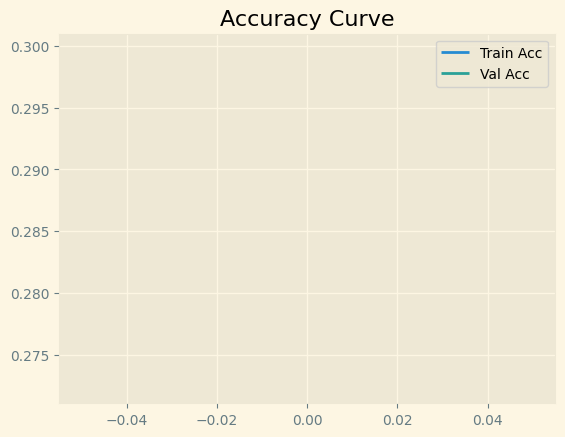

In [24]:
plt.figure()
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy Curve")
mlflow.log_figure(plt.gcf(), "accuracy_curve.png")
plt.show()

In [ ]:
# loss, accuracy = model.evaluate(X_val,y_val)
# print(f"Test Loss: {loss}")
# print(f"Test Accuracy: {accuracy}")

869/869 [==============================] - 13s 15ms/step - loss: 0.5538 - accuracy: 0.3084
Test Loss: 0.5537537932395935
Test Accuracy: 0.3084256649017334


In [25]:
from mlflow.types import Schema, TensorSpec
from mlflow.models import ModelSignature
import numpy as np
input_schema = Schema([
    TensorSpec(np.dtype(np.float32), (-1, timestep, input_nodes), "input")
])
output_schema = Schema([
    TensorSpec(np.dtype(np.float32), (-1, num_classes), "output")
])
signature = ModelSignature(inputs=input_schema, outputs=output_schema)

In [26]:
# ---- Log Model ----
mlflow.tensorflow.log_model(model, "model",signature=signature)

INFO:tensorflow:Assets written to: C:\Users\SriRam.A\AppData\Local\Temp\tmpilb29oan\model\data\model\assets


869/869 [==============================] - 9s 10ms/step


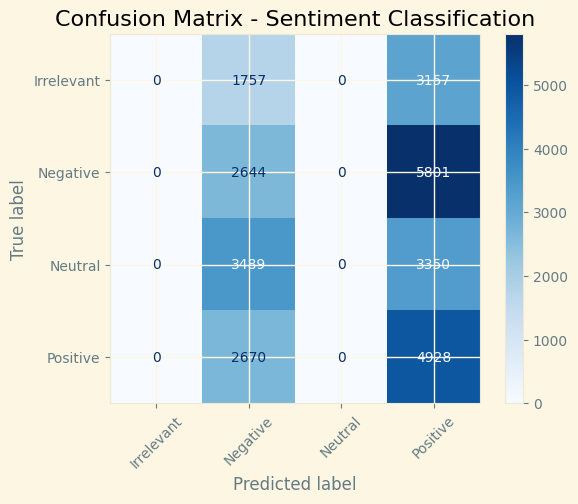


Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.00      0.00      0.00      4914
    Negative       0.25      0.31      0.28      8445
     Neutral       0.00      0.00      0.00      6839
    Positive       0.29      0.65      0.40      7598

    accuracy                           0.27     27796
   macro avg       0.13      0.24      0.17     27796
weighted avg       0.15      0.27      0.19     27796



<Figure size 640x480 with 0 Axes>

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# 1️⃣ Make predictions on the validation (test) data
y_pred = model.predict(X_val)

# 2️⃣ Convert probabilities → class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)

# 3️⃣ Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# 4️⃣ Display it visually
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix - Sentiment Classification")
plt.show()
mlflow.log_figure(plt.gcf(), "confusion_matrix.png")
# 5️⃣ Optional: detailed classification metrics
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_))


In [28]:
mlflow.end_run()

In [29]:
active_run = mlflow.active_run()
if active_run:
    print("✅ Active Run:")
    print(f"Run ID: {active_run.info.run_id}")
    print(f"Run Name: {active_run.data.tags.get('mlflow.runName', 'Unnamed')}")
else:
    print("❌ No active run.")

❌ No active run.
